# Ground Observatory Data - FTP

> Authors: Luca Mariani, Clemens Kloss
>
> Abstract: Demonstrates ground observatory data by direct access to the  BGS FTP server (AUX_OBS dataset). Note that in the future there will be a VirES-based access method (work in progress).

<a id="top"/>

## Contents

- [Settings and functions](#settings)
- [Hourly mean values](#obs)
    - [Read data from ASCII files](#obs-read-ascii)
    - [Read data from multiple files](#obs-multifiles)
    - [Examples](#obs-examples)
- [Minute and second mean values](#obsms)
    - [Read data from CDF files](#obsms-read-cdf)
    - [Read data from multiple files](#obsms-multifiles)

In [1]:
%load_ext watermark
%watermark -i -v -p viresclient,pandas,xarray,matplotlib

2021-01-24T16:12:44+00:00

CPython 3.7.6
IPython 7.11.1

viresclient 0.7.1
pandas 0.25.3
xarray 0.15.0
matplotlib 3.1.2


In [2]:
# Python standard library
import os
import re
from contextlib import closing
from datetime import datetime
from ftplib import FTP
from pathlib import Path
from tempfile import TemporaryFile
from zipfile import ZipFile

# Extra libraries
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cdflib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from viresclient import SwarmRequest

<a id="settings" />

## Settings and functions

[[TOP]](#top)

First we define a number of functions to enable convenient searching, downloading and reading from the FTP server.

In [3]:
# FTP server
HOST = 'ftp.nerc-murchison.ac.uk'

# Local directories (update paths according to your environment)
OBS_HOUR_LOCAL_DIR = Path('~/data/AUX_OBS/hour').expanduser()
OBS_MINUTE_LOCAL_DIR = Path('~/data/AUX_OBS/minute').expanduser()
OBS_SECOND_LOCAL_DIR = Path('~/data/AUX_OBS/second').expanduser()

# Create directories to use
os.makedirs(OBS_HOUR_LOCAL_DIR, exist_ok=True)
os.makedirs(OBS_MINUTE_LOCAL_DIR, exist_ok=True)
os.makedirs(OBS_SECOND_LOCAL_DIR, exist_ok=True)


def search(obstype, start_date=None, end_date=None):
    """Search OBS data file on the FTP server.

    Parameters
    ----------
    obstype : str
        OBS file type: `hour`, `minute`, `second`.
    start_date : str or numpy.datetime64
        lower bound of the time interval (default: no time interval).
    stop_date : str or numpy.datetime64
        upper bound of the time interval (default: no time interval).
    
    Returns
    -------
    list(str)
        OBS data files.
        
    Raises
    ------
    ValueError
        if `obstype` is not valid.
    ftplib.all_errors
        in case of FTP errors.
    
    """

    OBS_HOUR_DIR = '/geomag/Swarm/AUX_OBS/hour'
    OBS_MINUTE_DIR = '/geomag/Swarm/AUX_OBS/minute'
    OBS_SECOND_DIR = '/geomag/Swarm/AUX_OBS/second'
    PATTERN = re.compile(
        r'SW_OPER_AUX_OBS[_MS]2__(?P<start>\d{8}T\d{6})_'
        r'(?P<stop>\d{8}T\d{6})_\d{4}\.ZIP$'
    )
    MINDATE = np.datetime64('0000', 's')
    MAXDATE = np.datetime64('9999', 's')
    
    def _callback(line, result, start_date, end_date):
        if line[0] == '-':
            match = PATTERN.match(line[56:])
            if match:
                start, stop = match.groupdict().values()
                start = np.datetime64(datetime.strptime(start, '%Y%m%dT%H%M%S'))
                stop = np.datetime64(datetime.strptime(stop, '%Y%m%dT%H%M%S'))
                if end_date >= start and start_date <= stop:
                    result.append(line[56:])

    start_date = MINDATE if start_date is None else np.datetime64(start_date)
    end_date = MAXDATE if end_date is None else np.datetime64(end_date)
    paths = {
        'hour': OBS_HOUR_DIR,
        'minute': OBS_MINUTE_DIR,
        'second': OBS_SECOND_DIR
    }
    if obstype not in paths:
        raise ValueError(
            f'obstype must be hour, minute or second, not {obstype}'
        )

    result = []
    with FTP(HOST) as ftp:
        ftp.login()
        ftp.dir(paths[obstype], lambda line: _callback(line, result, start_date, end_date))
    return [f'{paths[obstype]}/{name}' for name in sorted(result)]


def loacal_search(obstype, start_date=None, end_date=None):
    """Search OBS data file on local filesystem.

    Parameters
    ----------
    obstype : str
        OBS file type: `hour`, `minute`, `second`.
    start_date : str or numpy.datetime64
        lower bound of the time interval (default: no time interval).
    stop_date : str or numpy.datetime64
        upper bound of the time interval (default: no time interval).
    
    Returns
    -------
    list(pathlib.Path)
        OBS data files.
        
    Raises
    ------
    ValueError
        if `obstype` is not valid.
    
    """

    PATTERN = re.compile(
        r'SW_OPER_AUX_OBS[_MS]2__(?P<start>\d{8}T\d{6})_'
        r'(?P<stop>\d{8}T\d{6})_\d{4}\.\w{3}$'
    )
    MINDATE = np.datetime64('0000', 's')
    MAXDATE = np.datetime64('9999', 's')
    
    start_date = MINDATE if start_date is None else np.datetime64(start_date)
    end_date = MAXDATE if end_date is None else np.datetime64(end_date)
    paths = {
        'hour': OBS_HOUR_LOCAL_DIR,
        'minute': OBS_MINUTE_LOCAL_DIR,
        'second': OBS_SECOND_LOCAL_DIR
    }
    if obstype not in paths:
        raise ValueError(
            f'obstype must be hour, minute or second, not {obstype}'
        )

    result = []
    for file in (elm for elm in paths[obstype].iterdir() if elm.is_file()):
        match = PATTERN.match(file.name)
        if match:
            start, stop = match.groupdict().values()
            start = np.datetime64(datetime.strptime(start, '%Y%m%dT%H%M%S'))
            stop = np.datetime64(datetime.strptime(stop, '%Y%m%dT%H%M%S'))
            if end_date >= start and start_date <= stop:
                result.append(file)
    return sorted(result)


def download(files, outdir='', show_progress=True):
    """Download files from the FTP server.

    Parameters
    ----------
    outdir : str or os.PathLike
        output directory (default: current directory).
    files : collections.abc.Iterable(str)
        path(s) of the file(s) to be downloaded
    
    Returns
    -------
    list(pathlib.Path)
        list of downloaded files.
        
    Raises
    ------
    ftplib.all_errors
        in case of FTP errors.
    
    """
    def _callback(data, fh, pbar):
        pbar.update(len(data))
        fh.write(data)

    outdir = Path(outdir)
    downloaded = []
    with FTP(HOST) as ftp:
        ftp.login()
        for file in files:
            file = str(file)
            basename = file.split('/')[-1]
            with TemporaryFile(dir=outdir) as tmp:
                with tqdm(total=ftp.size(file), unit='B',
                          unit_scale=True, desc=basename,
                          disable=not show_progress) as pbar:
                    ftp.retrbinary(f'RETR {file}', callback=lambda x: _callback(x, tmp, pbar))
                    with ZipFile(tmp) as zf:
                        hdr = Path(basename).with_suffix('.HDR').name
                        datafile = [elm for elm in zf.namelist()if elm != hdr][0]
                        outfile = zf.extract(datafile, outdir)
                        downloaded.append(Path(outfile))
    return downloaded


def ascii_to_pandas(file):
    """Convert an OBS ASCII file to a pandas DataFrame.
    
    Parameters
    ----------
    file : str or os.PathLike
        OBS ASCII file.
    
    Returns
    -------
    pandas.DataFrame
        data contained in the OBS ASCII file.

    """
    df = pd.read_csv(
        file,
        comment='#',
        delim_whitespace=True,
        names = ['IAGA_code', 'Latitude', 'Longitude', 'Radius',
                 'yyyy', 'mm', 'dd', 'UT', 'B_N', 'B_E', 'B_C'],
        parse_dates={'Timestamp': [4, 5, 6]},
        infer_datetime_format=True
    )
    df['Timestamp'] = df['Timestamp'] + pd.to_timedelta(df['UT'], 'h')
    df.drop(columns='UT', inplace=True)
    df.set_index('Timestamp', inplace=True)
    return df


def cdf_to_pandas(file):
    """Convert an OBS CDF file to a pandas DataFrame.
    
    Parameters
    ----------
    file : str or os.PathLike
        OBS CDF file.
    
    Returns
    -------
    pandas.DataFrame
        data contained in the OBS CDF file.

    """
    with closing(cdflib.cdfread.CDF(file)) as data:
        ts = pd.DatetimeIndex(
            cdflib.cdfepoch.encode(data.varget('Timestamp'), iso_8601=True),
            name='Timestamp'
        )
        df = pd.DataFrame(
            {
                'IAGA_code': data.varget('IAGA_code')[:,0,0],
                'Latitude': data.varget('Latitude'),
                'Longitude': data.varget('Longitude'),
                'Radius': data.varget('Radius'),
                'B_N': data.varget('B_NEC')[:,0],
                'B_E': data.varget('B_NEC')[:,1],
                'B_C': data.varget('B_NEC')[:,2]
            },
            index=ts
        )
    return df


def download_obslist(outdir=''):
    """Search observatory list file on the FTP server.

    Parameters
    ----------
    outdir : str or os.PathLike
        output directory (default: current directory).

    Returns
    -------
    str
        Observatory list file.
        
    Raises
    ------
    ftplib.all_errors
        in case of FTP errors.
    
    """

    OBS_HOUR_DIR = '/geomag/Swarm/AUX_OBS/hour'
    
    def _callback(line, result):
        if line[0] == '-':
            match = re.match('obslist.+_gd\.all$', line[56:])
            if match:
                result.append(line[56:])

    outdir = Path(outdir)
    files = []
    with FTP(HOST) as ftp:
        ftp.login()
        ftp.dir(OBS_HOUR_DIR, lambda line: _callback(line, files))
        remote_obslist_file = f'{OBS_HOUR_DIR}/{files[0]}'
        local_obslist_file = outdir / files[0]
        with local_obslist_file.open('w') as fh:
            ftp.retrlines(f'RETR {remote_obslist_file}', lambda line: print(line, file=fh))
    return local_obslist_file
        

def read_obslist(file):
    """Convert observatory list  ASCII file to a pandas DataFrame.
    
    Parameters
    ----------
    file : str or os.PathLike
        observatory list ASCII file.
    
    Returns
    -------
    pandas.DataFrame
        data contained in the observatory list ASCII file.

    """
    df = pd.read_csv(
        file,
        delim_whitespace=True,
        names = ['IAGA_code', 'Latitude', 'Longitude', 'Altitude'],
    )
    return df

<a id="obs" />

## Hourly mean values

[[TOP]](#top)

Hourly means hosted at:
- ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/hour/

Processing methodology:
- Macmillan, S., Olsen, N. Observatory data and the Swarm mission. Earth Planet Sp 65, 15 (2013). https://doi.org/10.5047/eps.2013.07.011

<a id="obs-read-ascii" />

### Read data from ASCII files

[[TOP]](#top)

Use the `search()` function (see [Settings and functions](#settings)) to search OBS hourly data from 2018-01-01T00:00:00 to 2019-12-31T23:59:59 on the FTP server:

In [4]:
result = search('hour', '2018-01-01', '2019-12-31T23:59:59')
result

['/geomag/Swarm/AUX_OBS/hour/SW_OPER_AUX_OBS_2__20180101T000000_20181231T235959_0125.ZIP',
 '/geomag/Swarm/AUX_OBS/hour/SW_OPER_AUX_OBS_2__20190101T000000_20191231T235959_0125.ZIP']

Use the `download()` function (see [Settings and functions](#settings)) to download data:

In [5]:
downloaded = download(result, outdir=OBS_HOUR_LOCAL_DIR)
downloaded

SW_OPER_AUX_OBS_2__20180101T000000_20181231T235959_0125.ZIP: 100%|██████████| 6.44M/6.44M [00:02<00:00, 2.26MB/s]
SW_OPER_AUX_OBS_2__20190101T000000_20191231T235959_0125.ZIP: 100%|██████████| 5.66M/5.66M [00:02<00:00, 2.18MB/s]


[PosixPath('/home/jovyan/data/AUX_OBS/hour/SW_OPER_AUX_OBS_2__20180101T000000_20181231T235959_0125.txt'),
 PosixPath('/home/jovyan/data/AUX_OBS/hour/SW_OPER_AUX_OBS_2__20190101T000000_20191231T235959_0125.txt')]

Select one of the AUX_OBS_2_ files (e.g. the first one):

In [6]:
file1 = downloaded[0]
file1

PosixPath('/home/jovyan/data/AUX_OBS/hour/SW_OPER_AUX_OBS_2__20180101T000000_20181231T235959_0125.txt')

Read ASCII file and convert data to a `pandas.DataFrame`:

In [7]:
df1 = pd.read_csv(
    file1,
    comment='#',
    delim_whitespace=True,
    names = ['IAGA_code', 'Latitude', 'Longitude',
             'Radius', 'yyyy', 'mm', 'dd', 'UT', 'B_N', 'B_E', 'B_C'],
    parse_dates={'Timestamp': [4, 5, 6]},
    infer_datetime_format=True
)
df1['Timestamp'] = df1['Timestamp'] + pd.to_timedelta(df1['UT'], 'h')
df1.drop(columns='UT', inplace=True)
df1.set_index('Timestamp', inplace=True)

df1

IAGA_code  Latitude  Longitude    Radius      B_N     B_E  \
Timestamp                                                                       
2018-01-01 00:30:00      ABG1    18.517     72.867  6375.977  38137.1   236.0   
2018-01-01 01:30:00      ABG1    18.517     72.867  6375.977  38140.1   232.0   
2018-01-01 02:30:00      ABG1    18.517     72.867  6375.977  38144.1   227.0   
2018-01-01 03:30:00      ABG1    18.517     72.867  6375.977  38160.1   228.0   
2018-01-01 04:30:00      ABG1    18.517     72.867  6375.977  38157.1   230.0   
...                       ...       ...        ...       ...      ...     ...   
2018-12-31 19:30:00      YAK1    61.807    129.667  6361.607  13221.4 -4982.0   
2018-12-31 20:30:00      YAK1    61.807    129.667  6361.607  13221.4 -4983.0   
2018-12-31 21:30:00      YAK1    61.807    129.667  6361.607  13222.4 -4986.0   
2018-12-31 22:30:00      YAK1    61.807    129.667  6361.607  13224.4 -4983.0   
2018-12-31 23:30:00      YAK1    61.807    129.667  6361.607  13225.4 -4985.0   

                         B_C  
Timestamp                     
2018-01-01 00:30:00  20211.4  
2018-01-01 01:30:00  20209.4  
2018-01-01 02:30:00  20211.4  
2018-01-01 03:30:00  20216.4  
2018-01-01 04:30:00  20221.4  
...                      ...  
2018-12-31 19:30:00  58249.1  
2018-12-31 20:30:00  58250.1  
2018-12-31 21:30:00  58250.1  
2018-12-31 22:30:00  58249.1  
2018-12-31 23:30:00  58249.1  

[896627 rows x 7 columns]

For more information on `pandas.Dataframe` see: https://pandas.pydata.org/docs/reference/frame.

The same result can be obtained with the `ascii_to_pandas()` function (see [Settings and functions](#settings)).

In [8]:
new = ascii_to_pandas(file1)
new

IAGA_code  Latitude  Longitude    Radius      B_N     B_E  \
Timestamp                                                                       
2018-01-01 00:30:00      ABG1    18.517     72.867  6375.977  38137.1   236.0   
2018-01-01 01:30:00      ABG1    18.517     72.867  6375.977  38140.1   232.0   
2018-01-01 02:30:00      ABG1    18.517     72.867  6375.977  38144.1   227.0   
2018-01-01 03:30:00      ABG1    18.517     72.867  6375.977  38160.1   228.0   
2018-01-01 04:30:00      ABG1    18.517     72.867  6375.977  38157.1   230.0   
...                       ...       ...        ...       ...      ...     ...   
2018-12-31 19:30:00      YAK1    61.807    129.667  6361.607  13221.4 -4982.0   
2018-12-31 20:30:00      YAK1    61.807    129.667  6361.607  13221.4 -4983.0   
2018-12-31 21:30:00      YAK1    61.807    129.667  6361.607  13222.4 -4986.0   
2018-12-31 22:30:00      YAK1    61.807    129.667  6361.607  13224.4 -4983.0   
2018-12-31 23:30:00      YAK1    61.807    129.667  6361.607  13225.4 -4985.0   

                         B_C  
Timestamp                     
2018-01-01 00:30:00  20211.4  
2018-01-01 01:30:00  20209.4  
2018-01-01 02:30:00  20211.4  
2018-01-01 03:30:00  20216.4  
2018-01-01 04:30:00  20221.4  
...                      ...  
2018-12-31 19:30:00  58249.1  
2018-12-31 20:30:00  58250.1  
2018-12-31 21:30:00  58250.1  
2018-12-31 22:30:00  58249.1  
2018-12-31 23:30:00  58249.1  

[896627 rows x 7 columns]

Compare the two data frames:

In [9]:
pd.testing.assert_frame_equal(df1, new)

Example: get minimum and maximum dates:

In [10]:
df1.index.min(), df1.index.max()

(Timestamp('2018-01-01 00:30:00'), Timestamp('2018-12-31 23:30:00'))

Example: get list of observatories (IAGA codes) stored in the files:

In [11]:
df1['IAGA_code'].unique()

array(['ABG1', 'ABK0', 'API2', 'ARS0', 'ASC0', 'ASP0', 'BDV0', 'BEL0',
       'BFO0', 'BJN1', 'BMT1', 'BOU0', 'BOX0', 'BRW0', 'BSL1', 'CKI0',
       'CLF0', 'CMO3', 'CNB0', 'CPL0', 'CSY1', 'CTA0', 'CYG0', 'DLT0',
       'DOB1', 'DOU0', 'EBR0', 'ESK0', 'EYR0', 'FCC0', 'FRD0', 'FRN0',
       'FUR0', 'GCK0', 'GDH2', 'GNG0', 'GUA0', 'HAD0', 'HBK0', 'HER0',
       'HLP0', 'HON3', 'HRB0', 'HRN0', 'HYB0', 'IQA1', 'IRT2', 'IZN0',
       'JCO0', 'KAK0', 'KDU0', 'KEP0', 'KHB0', 'KIV2', 'KMH1', 'KNY0',
       'KOU0', 'LER0', 'LON0', 'LRM0', 'LRV0', 'LVV2', 'LYC0', 'LZH1',
       'MAB0', 'MAW0', 'MBO0', 'MCQ0', 'MEA0', 'MGD0', 'MMB0', 'NAQ0',
       'NCK0', 'NEW0', 'NGK0', 'NMP1', 'NVS0', 'OTT0', 'PET2', 'PHU1',
       'PIL0', 'PST0', 'RES0', 'SBA0', 'SBL0', 'SFS2', 'SHE0', 'SHU0',
       'SIT2', 'SPT0', 'STJ0', 'SUA1', 'TAM0', 'THL0', 'THY0', 'TRO0',
       'TSU0', 'TUC2', 'UPS0', 'VIC0', 'VNA0', 'VOS3', 'VSS0', 'WIC0',
       'WNG0', 'YAK1'], dtype=object)

<a id="obs-multifiles" />

### Read data from multiple files

[[TOP]](#top)

Pandas dataframes can be concatenated to represent data obtained from more than one file. E.g. read data from the next AUX_OBS_2_ file:

In [12]:
file2 = downloaded[1]
df2 = ascii_to_pandas(file2)
df2

IAGA_code  Latitude  Longitude    Radius      B_N     B_E  \
Timestamp                                                                       
2019-01-01 00:30:00      ABG1    18.517     72.867  6375.977  38172.8   259.0   
2019-01-01 01:30:00      ABG1    18.517     72.867  6375.977  38170.8   262.0   
2019-01-01 02:30:00      ABG1    18.517     72.867  6375.977  38171.8   269.0   
2019-01-01 03:30:00      ABG1    18.517     72.867  6375.977  38171.8   278.0   
2019-01-01 04:30:00      ABG1    18.517     72.867  6375.977  38173.9   275.0   
...                       ...       ...        ...       ...      ...     ...   
2019-12-28 19:30:00      WNG0    53.566      9.067  6364.320  18045.5   996.5   
2019-12-28 20:30:00      WNG0    53.566      9.067  6364.320  18045.5   998.6   
2019-12-28 21:30:00      WNG0    53.566      9.067  6364.320  18044.4  1000.9   
2019-12-28 22:30:00      WNG0    53.566      9.067  6364.320  18041.9  1000.3   
2019-12-28 23:30:00      WNG0    53.566      9.067  6364.320  18040.9   999.9   

                         B_C  
Timestamp                     
2019-01-01 00:30:00  20335.5  
2019-01-01 01:30:00  20338.5  
2019-01-01 02:30:00  20341.5  
2019-01-01 03:30:00  20336.5  
2019-01-01 04:30:00  20321.5  
...                      ...  
2019-12-28 19:30:00  46391.1  
2019-12-28 20:30:00  46391.8  
2019-12-28 21:30:00  46392.3  
2019-12-28 22:30:00  46391.3  
2019-12-28 23:30:00  46391.7  

[728157 rows x 7 columns]

The two dataframes can be concatenated using the `pandas.concat()` function (for more information see: https://pandas.pydata.org/docs/reference/api/pandas.concat.html#pandas.concat):

In [13]:
concatenated = pd.concat([df1, df2])
concatenated.sort_values(by=['IAGA_code', 'Timestamp'], inplace=True)

concatenated.index.min(), concatenated.index.max()

(Timestamp('2018-01-01 00:30:00'), Timestamp('2019-12-31 23:30:00'))

In [14]:
concatenated

IAGA_code  Latitude  Longitude    Radius      B_N     B_E  \
Timestamp                                                                       
2018-01-01 00:30:00      ABG1    18.517     72.867  6375.977  38137.1   236.0   
2018-01-01 01:30:00      ABG1    18.517     72.867  6375.977  38140.1   232.0   
2018-01-01 02:30:00      ABG1    18.517     72.867  6375.977  38144.1   227.0   
2018-01-01 03:30:00      ABG1    18.517     72.867  6375.977  38160.1   228.0   
2018-01-01 04:30:00      ABG1    18.517     72.867  6375.977  38157.1   230.0   
...                       ...       ...        ...       ...      ...     ...   
2018-12-31 19:30:00      YAK1    61.807    129.667  6361.607  13221.4 -4982.0   
2018-12-31 20:30:00      YAK1    61.807    129.667  6361.607  13221.4 -4983.0   
2018-12-31 21:30:00      YAK1    61.807    129.667  6361.607  13222.4 -4986.0   
2018-12-31 22:30:00      YAK1    61.807    129.667  6361.607  13224.4 -4983.0   
2018-12-31 23:30:00      YAK1    61.807    129.667  6361.607  13225.4 -4985.0   

                         B_C  
Timestamp                     
2018-01-01 00:30:00  20211.4  
2018-01-01 01:30:00  20209.4  
2018-01-01 02:30:00  20211.4  
2018-01-01 03:30:00  20216.4  
2018-01-01 04:30:00  20221.4  
...                      ...  
2018-12-31 19:30:00  58249.1  
2018-12-31 20:30:00  58250.1  
2018-12-31 21:30:00  58250.1  
2018-12-31 22:30:00  58249.1  
2018-12-31 23:30:00  58249.1  

[1624784 rows x 7 columns]

<a id="obs-examples"/>

### Examples

[[TOP]](#top)

Plot hourly mean values on a map:

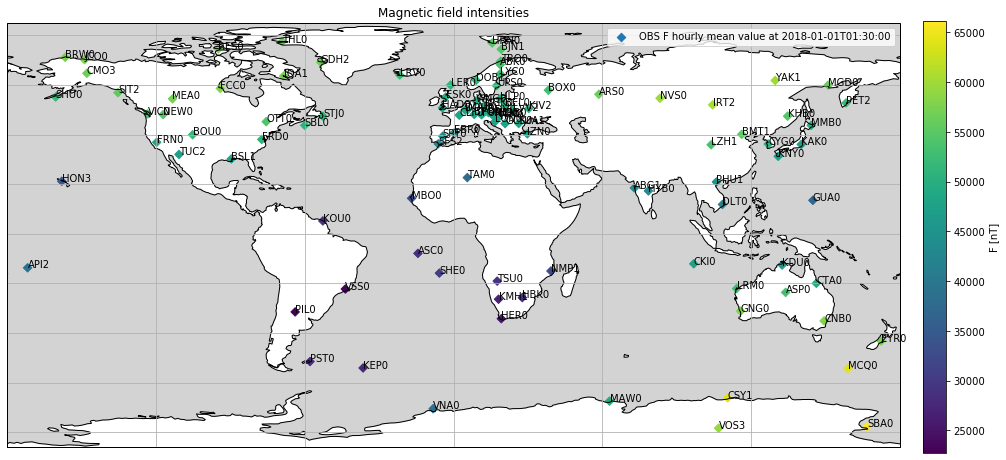

In [15]:
df = ascii_to_pandas(file1)

# Add F column
df['F'] = np.linalg.norm(df[['B_N', 'B_E', 'B_C']], axis=1)

# Select date
date = '2018-01-01T01:30:00'

fig = plt.figure(figsize=(16, 10))

# Draw map
ax = plt.subplot2grid((1, 1), (0, 0), projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.OCEAN, facecolor='lightgrey')
ax.gridlines()

# Plot observatory measurements at date
cm = ax.scatter(
    df[date]['Longitude'], df[date]['Latitude'], c=df[date]['F'],
    marker='D', transform=ccrs.PlateCarree(),
    label=f'OBS F hourly mean value at {date}'
)

# Add IAGA codes
for row in df[date].itertuples():
    ax.annotate(
        row.IAGA_code, (row.Longitude, row.Latitude),
        xycoords=ccrs.PlateCarree()._as_mpl_transform(ax)
    )

# Set title and legendbb
plt.title('Magnetic field intensities')
plt.legend()

# Add colorbar
cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
plt.colorbar(cm, cax=cax, label='F [nT]')

plt.show()

Read list of all observatories (use the `download_obslist()` and `read_obslist()` functions defined in [Settings and functions](#settings)):

In [16]:
obslist = download_obslist(outdir=OBS_HOUR_LOCAL_DIR)
obslist

PosixPath('/home/jovyan/data/AUX_OBS/hour/obslist19002020_0125_gd.all')

In [17]:
obs = read_obslist(obslist)
obs

IAGA_code  Latitude  Longitude  Altitude
0        AAA0    43.250     76.917     1.300
1        AAE0     9.033     38.767     2.441
2        AAE1     9.033     38.767     2.441
3        ABG0    18.633     72.867     0.007
4        ABG1    18.633     72.867     0.007
..        ...       ...        ...       ...
245      WNG0    53.750      9.067     0.050
246      YAK0    61.967    129.667     0.100
247      YAK1    61.967    129.667     0.100
248      YKC2    62.483    245.517     0.198
249      YSS0    46.950    142.717     0.070

[250 rows x 4 columns]

Add the missing observatories, i.e. those not included in the observatory hourly mean values, to the plot:

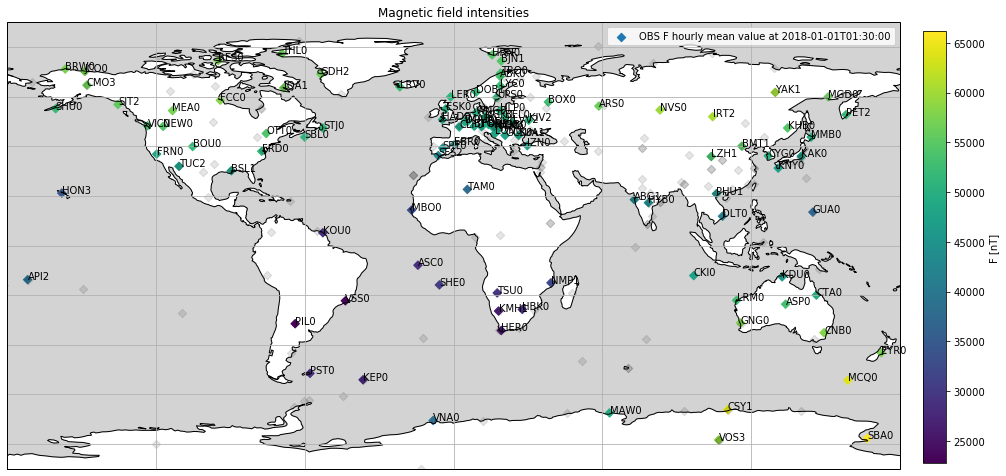

In [18]:
df = ascii_to_pandas(file1)

# Add F column
df['F'] = np.linalg.norm(df[['B_N', 'B_E', 'B_C']], axis=1)

# Select date
date = '2018-01-01T01:30:00'

fig = plt.figure(figsize=(16, 10))

# Draw map
ax = plt.subplot2grid((1, 1), (0, 0), projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.OCEAN, facecolor='lightgrey')
ax.gridlines()

# Plot observatory measurements at date
cm = ax.scatter(
    df[date]['Longitude'], df[date]['Latitude'], c=df[date]['F'],
    marker='D', transform=ccrs.PlateCarree(),
    label=f'OBS F hourly mean value at {date}'
)

# Add IAGA codes
for row in df[date].itertuples():
    ax.annotate(
        row.IAGA_code, (row.Longitude, row.Latitude),
        xycoords=ccrs.PlateCarree()._as_mpl_transform(ax)
    )

# Add missing observatories from obslist (position only)
missing = obs[~obs['IAGA_code'].isin(df[date]['IAGA_code'].unique())]
cm2 = ax.scatter(missing['Longitude'], missing['Latitude'], c='black', marker='D', alpha=0.1)

# Set title and legendbb
plt.title('Magnetic field intensities')
plt.legend()

# Add colorbar
cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
plt.colorbar(cm, cax=cax, label='F [nT]')

plt.show()

Add Swarm F measurements between 01:00:00 and 02:00:00 of the same day:

In [19]:
# using viresclient
request = SwarmRequest()
request.set_collection('SW_OPER_MAGA_LR_1B')
request.set_products(measurements='F')

start_date = '2018-01-01T01:00:00'
end_date = '2018-01-01T02:00:00'

data = request.get_between(start_date, end_date)

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.157MB)


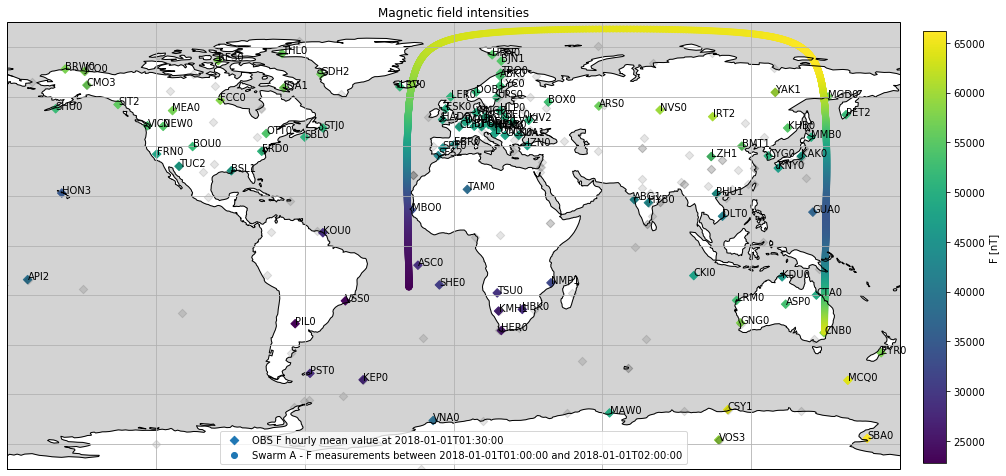

In [20]:
df = ascii_to_pandas(file1)

# Add F column
df['F'] = np.linalg.norm(df[['B_N', 'B_E', 'B_C']], axis=1)

# Select date
date = '2018-01-01T01:30:00'

fig = plt.figure(figsize=(16, 10))

# Draw map
ax = plt.subplot2grid((1, 1), (0, 0), projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.OCEAN, facecolor='lightgrey')
ax.gridlines()

# Plot observatory measurements at date
cm = ax.scatter(
    df[date]['Longitude'], df[date]['Latitude'], c=df[date]['F'],
    marker='D', transform=ccrs.PlateCarree(),
    label=f'OBS F hourly mean value at {date}'
)

# Add IAGA codes
for row in df[date].itertuples():
    ax.annotate(
        row.IAGA_code, (row.Longitude, row.Latitude),
        xycoords=ccrs.PlateCarree()._as_mpl_transform(ax)
    )

# Add missing observatories from obslist (position only)
missing = obs[~obs['IAGA_code'].isin(df[date]['IAGA_code'].unique())]
ax.scatter(missing['Longitude'], missing['Latitude'], c='black', marker='D', alpha=0.1)

# Add Swarm A data
swarm = data.as_dataframe()
ax.scatter(
    swarm['Longitude'], swarm['Latitude'], c=swarm['F'],
    transform=ccrs.PlateCarree(),
    label=f'Swarm A - F measurements between {start_date} and {end_date}'
)

# Set title and legendbb
plt.title('Magnetic field intensities')
plt.legend()

# Add colorbar
cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
plt.colorbar(cm, cax=cax, label='F [nT]')

plt.show()

<a id="obsms" />

## Minute and second mean values

[[TOP]](#top)

Files containing observatory minute and second mean values have CDF format. They can be downloade from:

- ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/
- ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/second/

<a id="obsms-read-cdf" />

### Read data from CDF files

[[TOP]](#top)

Use the `search()` function (see [Settings and functions](#settings)) to search OBS minute/second data from 2019-12-01T00:00:00 to 2019-12-31T23:59:59 on the FTP server:

In [21]:
minute = search('minute', '2019-12-01', '2019-12-31T23:59:59')
minute

['/geomag/Swarm/AUX_OBS/minute/SW_OPER_AUX_OBSM2__20191201T000000_20191201T235959_0104.ZIP',
 '/geomag/Swarm/AUX_OBS/minute/SW_OPER_AUX_OBSM2__20191202T000000_20191202T235959_0105.ZIP',
 '/geomag/Swarm/AUX_OBS/minute/SW_OPER_AUX_OBSM2__20191203T000000_20191203T235959_0105.ZIP',
 '/geomag/Swarm/AUX_OBS/minute/SW_OPER_AUX_OBSM2__20191204T000000_20191204T235959_0104.ZIP',
 '/geomag/Swarm/AUX_OBS/minute/SW_OPER_AUX_OBSM2__20191205T000000_20191205T235959_0105.ZIP',
 '/geomag/Swarm/AUX_OBS/minute/SW_OPER_AUX_OBSM2__20191206T000000_20191206T235959_0107.ZIP',
 '/geomag/Swarm/AUX_OBS/minute/SW_OPER_AUX_OBSM2__20191207T000000_20191207T235959_0106.ZIP',
 '/geomag/Swarm/AUX_OBS/minute/SW_OPER_AUX_OBSM2__20191208T000000_20191208T235959_0105.ZIP',
 '/geomag/Swarm/AUX_OBS/minute/SW_OPER_AUX_OBSM2__20191209T000000_20191209T235959_0105.ZIP',
 '/geomag/Swarm/AUX_OBS/minute/SW_OPER_AUX_OBSM2__20191210T000000_20191210T235959_0105.ZIP',
 '/geomag/Swarm/AUX_OBS/minute/SW_OPER_AUX_OBSM2__20191211T000000_2019

In [22]:
second = search('second', '2019-12-01', '2019-12-31T23:59:59')
second

['/geomag/Swarm/AUX_OBS/second/SW_OPER_AUX_OBSS2__20191201T000000_20191201T235959_0103.ZIP',
 '/geomag/Swarm/AUX_OBS/second/SW_OPER_AUX_OBSS2__20191202T000000_20191202T235959_0103.ZIP',
 '/geomag/Swarm/AUX_OBS/second/SW_OPER_AUX_OBSS2__20191203T000000_20191203T235959_0103.ZIP',
 '/geomag/Swarm/AUX_OBS/second/SW_OPER_AUX_OBSS2__20191204T000000_20191204T235959_0103.ZIP',
 '/geomag/Swarm/AUX_OBS/second/SW_OPER_AUX_OBSS2__20191205T000000_20191205T235959_0103.ZIP',
 '/geomag/Swarm/AUX_OBS/second/SW_OPER_AUX_OBSS2__20191206T000000_20191206T235959_0102.ZIP',
 '/geomag/Swarm/AUX_OBS/second/SW_OPER_AUX_OBSS2__20191207T000000_20191207T235959_0102.ZIP',
 '/geomag/Swarm/AUX_OBS/second/SW_OPER_AUX_OBSS2__20191208T000000_20191208T235959_0102.ZIP',
 '/geomag/Swarm/AUX_OBS/second/SW_OPER_AUX_OBSS2__20191209T000000_20191209T235959_0103.ZIP',
 '/geomag/Swarm/AUX_OBS/second/SW_OPER_AUX_OBSS2__20191210T000000_20191210T235959_0103.ZIP',
 '/geomag/Swarm/AUX_OBS/second/SW_OPER_AUX_OBSS2__20191211T000000_2019

Use the `download()` function (see [Settings and functions](#settings)) to download data:

In [23]:
dl_minute = download(minute, outdir=OBS_MINUTE_LOCAL_DIR)

SW_OPER_AUX_OBSM2__20191201T000000_20191201T235959_0104.ZIP: 100%|██████████| 1.51M/1.51M [00:00<00:00, 1.86MB/s]
SW_OPER_AUX_OBSM2__20191202T000000_20191202T235959_0105.ZIP: 100%|██████████| 1.40M/1.40M [00:00<00:00, 1.87MB/s]
SW_OPER_AUX_OBSM2__20191203T000000_20191203T235959_0105.ZIP: 100%|██████████| 1.47M/1.47M [00:00<00:00, 1.90MB/s]
SW_OPER_AUX_OBSM2__20191204T000000_20191204T235959_0104.ZIP: 100%|██████████| 1.52M/1.52M [00:00<00:00, 1.91MB/s]
SW_OPER_AUX_OBSM2__20191205T000000_20191205T235959_0105.ZIP: 100%|██████████| 1.45M/1.45M [00:00<00:00, 1.89MB/s]
SW_OPER_AUX_OBSM2__20191206T000000_20191206T235959_0107.ZIP: 100%|██████████| 1.49M/1.49M [00:00<00:00, 1.88MB/s]
SW_OPER_AUX_OBSM2__20191207T000000_20191207T235959_0106.ZIP: 100%|██████████| 1.42M/1.42M [00:00<00:00, 1.90MB/s]
SW_OPER_AUX_OBSM2__20191208T000000_20191208T235959_0105.ZIP: 100%|██████████| 1.50M/1.50M [00:00<00:00, 1.89MB/s]
SW_OPER_AUX_OBSM2__20191209T000000_20191209T235959_0105.ZIP: 100%|██████████| 1.49M/1.49

In [24]:
dl_second = download(second, outdir=OBS_SECOND_LOCAL_DIR)

SW_OPER_AUX_OBSS2__20191201T000000_20191201T235959_0103.ZIP: 100%|██████████| 9.28M/9.28M [00:03<00:00, 2.51MB/s]
SW_OPER_AUX_OBSS2__20191202T000000_20191202T235959_0103.ZIP: 100%|██████████| 8.47M/8.47M [00:03<00:00, 2.41MB/s]
SW_OPER_AUX_OBSS2__20191203T000000_20191203T235959_0103.ZIP: 100%|██████████| 8.61M/8.61M [00:03<00:00, 2.49MB/s]
SW_OPER_AUX_OBSS2__20191204T000000_20191204T235959_0103.ZIP: 100%|██████████| 8.72M/8.72M [00:03<00:00, 2.46MB/s]
SW_OPER_AUX_OBSS2__20191205T000000_20191205T235959_0103.ZIP: 100%|██████████| 8.28M/8.28M [00:03<00:00, 2.46MB/s]
SW_OPER_AUX_OBSS2__20191206T000000_20191206T235959_0102.ZIP: 100%|██████████| 7.13M/7.13M [00:03<00:00, 2.36MB/s]
SW_OPER_AUX_OBSS2__20191207T000000_20191207T235959_0102.ZIP: 100%|██████████| 7.12M/7.12M [00:02<00:00, 2.49MB/s]
SW_OPER_AUX_OBSS2__20191208T000000_20191208T235959_0102.ZIP: 100%|██████████| 6.75M/6.75M [00:02<00:00, 2.42MB/s]
SW_OPER_AUX_OBSS2__20191209T000000_20191209T235959_0103.ZIP: 100%|██████████| 8.57M/8.57

Select one of the AUX_OBSM2_ files (e.g. the first one):

In [25]:
file1 = dl_minute[0]
file1

PosixPath('/home/jovyan/data/AUX_OBS/minute/SW_OPER_AUX_OBSM2__20191201T000000_20191201T235959_0104.DBL')

Read CDF file using `cdflib` (for more information on `cdflib`, see: https://github.com/MAVENSDC/cdflib)

In [26]:
data = cdflib.CDF(file1)

Get info about the file as a Python dictionary:

In [27]:
data.cdf_info()

{'CDF': PosixPath('/tmp/tmps6ww7ug3.cdf'),
 'Version': '3.6.3',
 'Encoding': 6,
 'Majority': 'Row_major',
 'rVariables': [],
 'zVariables': ['IAGA_code',
  'Quality',
  'Timestamp',
  'Longitude',
  'Latitude',
  'Radius',
  'B_NEC'],
 'Attributes': [{'TITLE': 'Global'},
  {'ACKNOWLEDGMENTS': 'Global'},
  {'UNITS': 'Variable'},
  {'DESCRIPTION': 'Variable'},
  {'FORMAT': 'Variable'}],
 'Copyright': '\nCommon Data Format (CDF)\n(C) Copyright 1990-2016 NASA/GSFC\nSpace Physics Data Facility\nNASA/Goddard Space Flight Center\nGreenbelt, Maryland 20771 USA\n(Internet -- GSFC-CDF-SUPPORT@LISTS.NASA.GOV)\n',
 'Checksum': False,
 'Num_rdim': 0,
 'rDim_sizes': [],
 'Compressed': True,
 'LeapSecondUpdated': 20170101}

You can see that measurements are stored as *zVariables*:

In [28]:
data.cdf_info()['zVariables']

['IAGA_code',
 'Quality',
 'Timestamp',
 'Longitude',
 'Latitude',
 'Radius',
 'B_NEC']

Data can be retrieved via the `.varget()` method, e.g:

In [29]:
data.varget('B_NEC')

array([[38201.54020881,   283.2       , 20443.37567268],
       [38201.44020902,   283.4       , 20443.37546999],
       [38201.44041172,   283.4       , 20443.27547019],
       ...,
       [18043.81479681,   994.14      , 46386.95702782],
       [18043.72486142,   994.09      , 46386.93673929],
       [18043.4948626 ,   994.08      , 46386.93600165]])

Data is returned as a `numpy.ndarray` object (for more information on `numpy.ndarray`, see: https://docs.scipy.org/doc/numpy/reference/arrays.ndarray.html).

Variable attributes can be retrieved using the `.varattsget()` method, e.g.:

In [30]:
data.varattsget('B_NEC')

{'UNITS': 'nT',
 'DESCRIPTION': 'Geocentric-north, east, and geocentric-down component of magnetic field.  NaN values are used as placeholders for missing data.',
 'FORMAT': 'F8.1'}

Attributes are returned as a Python dictionary.

Let's retrieve the timestamps:

In [31]:
data.varget('Timestamp')

array([6.37423776e+13, 6.37423777e+13, 6.37423777e+13, ...,
       6.37424638e+13, 6.37424639e+13, 6.37424639e+13])

`Timestamp` type is:

In [32]:
data.varget('Timestamp').dtype

dtype('float64')

Timestamps are represented as NumPy `float64` values. Why? Get info about `Timestamp` variable using the `.varinq()` method:

In [33]:
data.varinq('Timestamp')

{'Variable': 'Timestamp',
 'Num': 2,
 'Var_Type': 'zVariable',
 'Data_Type': 31,
 'Data_Type_Description': 'CDF_EPOCH',
 'Num_Elements': 1,
 'Num_Dims': 0,
 'Dim_Sizes': [],
 'Sparse': 'No_sparse',
 'Last_Rec': 115199,
 'Rec_Vary': True,
 'Dim_Vary': [],
 'Pad': array([0.]),
 'Compress': 0,
 'Block_Factor': 0}

The returned dictionary shows that the data type is *CDF_EPOCH* consising in a floating point value representing the number of milliseconds since 01-Jan-0000 00:00:00.000. It can be converted to a more readable format (list of strings) using the `cdflib.cdfepoch.encode()` function:

In [34]:
ts = cdflib.cdfepoch.encode(data.varget('Timestamp'), iso_8601=True)
ts[:5]

['2019-12-01T00:00:00.000',
 '2019-12-01T00:01:00.000',
 '2019-12-01T00:02:00.000',
 '2019-12-01T00:03:00.000',
 '2019-12-01T00:04:00.000']

Or to a numpy array of `numpy.datetime64` values:

In [35]:
ts = np.array(cdflib.cdfepoch.encode(data.varget('Timestamp'), iso_8601=True), dtype='datetime64')
ts[:5]

array(['2019-12-01T00:00:00.000', '2019-12-01T00:01:00.000',
       '2019-12-01T00:02:00.000', '2019-12-01T00:03:00.000',
       '2019-12-01T00:04:00.000'], dtype='datetime64[ms]')

You may be interested also in the CDF global attributes:

In [36]:
data.globalattsget()

{'TITLE': 'ESA Swarm level 2 auxiliary product: observatory definitive and/or quasi-definitive minute-mean data (AUX_OBSM2_)',
 'ACKNOWLEDGMENTS': 'The data presented in this product rely on data collected at magnetic observatories. We thank the national institutes that support them and INTERMAGNET for promoting high standards of magnetic observatory practice (www.intermagnet.org).'}

Close the file when you have finished:

In [37]:
data.close()

AUX_OBSS2_ data contains the same variables:

In [38]:
with closing(cdflib.cdfread.CDF(dl_second[0])) as data:
    zvariables = data.cdf_info()['zVariables']

zvariables

['IAGA_code',
 'Quality',
 'Timestamp',
 'Longitude',
 'Latitude',
 'Radius',
 'B_NEC']

Data can be represented as a `pandas.DataFrame` object:

In [39]:
with closing(cdflib.cdfread.CDF(file1)) as data:
    ts = pd.DatetimeIndex(
            cdflib.cdfepoch.encode(data.varget('Timestamp'), iso_8601=True),
            name='Timestamp'
        )
    df1 = pd.DataFrame(
        {
            'IAGA_code': data.varget('IAGA_code')[:,0,0],
            'Latitude': data.varget('Latitude'),
            'Longitude': data.varget('Longitude'),
            'Radius': data.varget('Radius'),
            'B_N': data.varget('B_NEC')[:,0],
            'B_E': data.varget('B_NEC')[:,1],
            'B_C': data.varget('B_NEC')[:,2]
        },
        index=ts
    )

df1

IAGA_code   Latitude  Longitude        Radius  \
Timestamp                                                           
2019-12-01 00:00:00       ABG  18.503863     72.870  6.375973e+06   
2019-12-01 00:01:00       ABG  18.503863     72.870  6.375973e+06   
2019-12-01 00:02:00       ABG  18.503863     72.870  6.375973e+06   
2019-12-01 00:03:00       ABG  18.503863     72.870  6.375973e+06   
2019-12-01 00:04:00       ABG  18.503863     72.870  6.375973e+06   
...                       ...        ...        ...           ...   
2019-12-01 23:55:00       WNG  53.541246      9.053  6.364329e+06   
2019-12-01 23:56:00       WNG  53.541246      9.053  6.364329e+06   
2019-12-01 23:57:00       WNG  53.541246      9.053  6.364329e+06   
2019-12-01 23:58:00       WNG  53.541246      9.053  6.364329e+06   
2019-12-01 23:59:00       WNG  53.541246      9.053  6.364329e+06   

                              B_N     B_E           B_C  
Timestamp                                                
2019-12-01 00:00:00  38201.540209  283.20  20443.375673  
2019-12-01 00:01:00  38201.440209  283.40  20443.375470  
2019-12-01 00:02:00  38201.440412  283.40  20443.275470  
2019-12-01 00:03:00  38200.940007  283.30  20443.474456  
2019-12-01 00:04:00  38200.739602  283.70  20443.674050  
...                           ...     ...           ...  
2019-12-01 23:55:00  18043.864764  993.95  46386.967188  
2019-12-01 23:56:00  18043.914732  994.07  46386.977348  
2019-12-01 23:57:00  18043.814797  994.14  46386.957028  
2019-12-01 23:58:00  18043.724861  994.09  46386.936739  
2019-12-01 23:59:00  18043.494863  994.08  46386.936002  

[115200 rows x 7 columns]

For more information on `pandas.Dataframe` see: https://pandas.pydata.org/docs/reference/frame.

The same result can be obtained with the `cdf_to_pandas()` function (see [Settings and functions](#settings)).

In [40]:
new = cdf_to_pandas(file1)

new

IAGA_code   Latitude  Longitude        Radius  \
Timestamp                                                           
2019-12-01 00:00:00       ABG  18.503863     72.870  6.375973e+06   
2019-12-01 00:01:00       ABG  18.503863     72.870  6.375973e+06   
2019-12-01 00:02:00       ABG  18.503863     72.870  6.375973e+06   
2019-12-01 00:03:00       ABG  18.503863     72.870  6.375973e+06   
2019-12-01 00:04:00       ABG  18.503863     72.870  6.375973e+06   
...                       ...        ...        ...           ...   
2019-12-01 23:55:00       WNG  53.541246      9.053  6.364329e+06   
2019-12-01 23:56:00       WNG  53.541246      9.053  6.364329e+06   
2019-12-01 23:57:00       WNG  53.541246      9.053  6.364329e+06   
2019-12-01 23:58:00       WNG  53.541246      9.053  6.364329e+06   
2019-12-01 23:59:00       WNG  53.541246      9.053  6.364329e+06   

                              B_N     B_E           B_C  
Timestamp                                                
2019-12-01 00:00:00  38201.540209  283.20  20443.375673  
2019-12-01 00:01:00  38201.440209  283.40  20443.375470  
2019-12-01 00:02:00  38201.440412  283.40  20443.275470  
2019-12-01 00:03:00  38200.940007  283.30  20443.474456  
2019-12-01 00:04:00  38200.739602  283.70  20443.674050  
...                           ...     ...           ...  
2019-12-01 23:55:00  18043.864764  993.95  46386.967188  
2019-12-01 23:56:00  18043.914732  994.07  46386.977348  
2019-12-01 23:57:00  18043.814797  994.14  46386.957028  
2019-12-01 23:58:00  18043.724861  994.09  46386.936739  
2019-12-01 23:59:00  18043.494863  994.08  46386.936002  

[115200 rows x 7 columns]

Compare the two data frames:

In [41]:
pd.testing.assert_frame_equal(df1, new)

Example: get minimum and maximum dates:

In [42]:
df1.index.min(), df1.index.max()

(Timestamp('2019-12-01 00:00:00'), Timestamp('2019-12-01 23:59:00'))

Example: get list of observatories (IAGA codes) stored in the files:

In [43]:
df1['IAGA_code'].unique()

array(['ABG', 'ABK', 'ASC', 'ASP', 'BEL', 'BFO', 'BMT', 'BOU', 'BOX',
       'BRD', 'BRW', 'BSL', 'CKI', 'CLF', 'CMO', 'CNB', 'CSY', 'CTA',
       'CYG', 'DLT', 'DOU', 'EBR', 'ESK', 'EYR', 'FRD', 'FRN', 'FUR',
       'GCK', 'GNG', 'GUA', 'HAD', 'HBK', 'HER', 'HLP', 'HON', 'IQA',
       'IRT', 'IZN', 'JCO', 'KAK', 'KDU', 'KEP', 'KMH', 'KNY', 'KOU',
       'LER', 'LON', 'LRM', 'LYC', 'MAB', 'MAW', 'MBO', 'MCQ', 'MGD',
       'MMB', 'NEW', 'NGK', 'NVS', 'ORC', 'PET', 'PIL', 'PST', 'SBA',
       'SBL', 'SFS', 'SHU', 'SIT', 'SJG', 'SUA', 'TAM', 'TDC', 'THY',
       'TSU', 'TUC', 'UPS', 'VNA', 'VOS', 'VSS', 'WIC', 'WNG'],
      dtype=object)

Example: get list of observatories (IAGA codes) included in the following ranges of coordinates:
- $30 \leq Latitude \leq 70$
- $-10 \leq Longitude \leq 40$

In [44]:
df1[(df1['Latitude'] >= 30) & (df1['Latitude'] <= 70) & (df1['Longitude'] >= -10) & (df1['Longitude'] <= 40)]['IAGA_code'].unique()

array(['ABK', 'BEL', 'BFO', 'BOX', 'CLF', 'DOU', 'EBR', 'FUR', 'GCK',
       'HLP', 'IZN', 'LON', 'LYC', 'MAB', 'NGK', 'SUA', 'THY', 'UPS',
       'WIC', 'WNG'], dtype=object)

You can do the same using the `.query()` method (see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.query.html#pandas.DataFrame.query):

In [45]:
df1.query('(30 <= Latitude <= 70) and (-10 <= Longitude <= 40)')['IAGA_code'].unique()

array(['ABK', 'BEL', 'BFO', 'BOX', 'CLF', 'DOU', 'EBR', 'FUR', 'GCK',
       'HLP', 'IZN', 'LON', 'LYC', 'MAB', 'NGK', 'SUA', 'THY', 'UPS',
       'WIC', 'WNG'], dtype=object)

<a id="obsms-multifiles" />

### Read data from multiple files

[[TOP]](#top)

Pandas dataframes can be concatenated to represent data obtained from more than one file. E.g. read data from the next AUX_OBSM2_ file:

In [46]:
file2 = dl_minute[1]

df2 = cdf_to_pandas(file2)

df2

IAGA_code   Latitude  Longitude        Radius  \
Timestamp                                                           
2019-12-02 00:00:00       ABG  18.503863     72.870  6.375973e+06   
2019-12-02 00:01:00       ABG  18.503863     72.870  6.375973e+06   
2019-12-02 00:02:00       ABG  18.503863     72.870  6.375973e+06   
2019-12-02 00:03:00       ABG  18.503863     72.870  6.375973e+06   
2019-12-02 00:04:00       ABG  18.503863     72.870  6.375973e+06   
...                       ...        ...        ...           ...   
2019-12-02 23:55:00       WNG  53.541246      9.053  6.364329e+06   
2019-12-02 23:56:00       WNG  53.541246      9.053  6.364329e+06   
2019-12-02 23:57:00       WNG  53.541246      9.053  6.364329e+06   
2019-12-02 23:58:00       WNG  53.541246      9.053  6.364329e+06   
2019-12-02 23:59:00       WNG  53.541246      9.053  6.364329e+06   

                              B_N     B_E           B_C  
Timestamp                                                
2019-12-02 00:00:00  38207.438981  282.90  20443.987631  
2019-12-02 00:01:00  38207.438981  283.00  20443.987631  
2019-12-02 00:02:00  38207.438981  283.00  20443.987631  
2019-12-02 00:03:00  38207.338778  283.00  20444.087428  
2019-12-02 00:04:00  38207.438778  282.90  20444.087630  
...                           ...     ...           ...  
2019-12-02 23:55:00  18043.801173  994.42  46388.086990  
2019-12-02 23:56:00  18043.431367  994.34  46388.025804  
2019-12-02 23:57:00  18043.621462  994.87  46387.996413  
2019-12-02 23:58:00  18043.801590  995.30  46387.956991  
2019-12-02 23:59:00  18043.591398  995.60  46388.016317  

[119520 rows x 7 columns]

The two dataframes can be concatenated using the `pandas.concat()` function (for more information see: https://pandas.pydata.org/docs/reference/api/pandas.concat.html#pandas.concat):

In [47]:
concatenated = pd.concat([df1, df2])
concatenated.sort_values(by=['IAGA_code', 'Timestamp'], inplace=True)

concatenated.index.min(), concatenated.index.max()

(Timestamp('2019-12-01 00:00:00'), Timestamp('2019-12-02 23:59:00'))

In [48]:
concatenated

IAGA_code   Latitude  Longitude        Radius  \
Timestamp                                                           
2019-12-01 00:00:00       ABG  18.503863     72.870  6.375973e+06   
2019-12-01 00:01:00       ABG  18.503863     72.870  6.375973e+06   
2019-12-01 00:02:00       ABG  18.503863     72.870  6.375973e+06   
2019-12-01 00:03:00       ABG  18.503863     72.870  6.375973e+06   
2019-12-01 00:04:00       ABG  18.503863     72.870  6.375973e+06   
...                       ...        ...        ...           ...   
2019-12-02 23:55:00       WNG  53.541246      9.053  6.364329e+06   
2019-12-02 23:56:00       WNG  53.541246      9.053  6.364329e+06   
2019-12-02 23:57:00       WNG  53.541246      9.053  6.364329e+06   
2019-12-02 23:58:00       WNG  53.541246      9.053  6.364329e+06   
2019-12-02 23:59:00       WNG  53.541246      9.053  6.364329e+06   

                              B_N     B_E           B_C  
Timestamp                                                
2019-12-01 00:00:00  38201.540209  283.20  20443.375673  
2019-12-01 00:01:00  38201.440209  283.40  20443.375470  
2019-12-01 00:02:00  38201.440412  283.40  20443.275470  
2019-12-01 00:03:00  38200.940007  283.30  20443.474456  
2019-12-01 00:04:00  38200.739602  283.70  20443.674050  
...                           ...     ...           ...  
2019-12-02 23:55:00  18043.801173  994.42  46388.086990  
2019-12-02 23:56:00  18043.431367  994.34  46388.025804  
2019-12-02 23:57:00  18043.621462  994.87  46387.996413  
2019-12-02 23:58:00  18043.801590  995.30  46387.956991  
2019-12-02 23:59:00  18043.591398  995.60  46388.016317  

[234720 rows x 7 columns]

With AUX_OBSS2_ data:

In [49]:
files = dl_second[:2]

files

[PosixPath('/home/jovyan/data/AUX_OBS/second/SW_OPER_AUX_OBSS2__20191201T000000_20191201T235959_0103.DBL'),
 PosixPath('/home/jovyan/data/AUX_OBS/second/SW_OPER_AUX_OBSS2__20191202T000000_20191202T235959_0103.DBL')]

In [50]:
concatenated = pd.concat([cdf_to_pandas(file) for file in files])
concatenated.sort_values(by=['IAGA_code', 'Timestamp'], inplace=True)

concatenated.index.min(), concatenated.index.max()

(Timestamp('2019-12-01 00:00:00'), Timestamp('2019-12-02 23:59:59'))

In [51]:
concatenated

IAGA_code   Latitude  Longitude        Radius  \
Timestamp                                                           
2019-12-01 00:00:00       BOX  57.897002      38.23  6.362885e+06   
2019-12-01 00:00:01       BOX  57.897002      38.23  6.362885e+06   
2019-12-01 00:00:02       BOX  57.897002      38.23  6.362885e+06   
2019-12-01 00:00:03       BOX  57.897002      38.23  6.362885e+06   
2019-12-01 00:00:04       BOX  57.897002      38.23  6.362885e+06   
...                       ...        ...        ...           ...   
2019-12-02 23:59:55       WIC  47.708527      15.90  6.367496e+06   
2019-12-02 23:59:56       WIC  47.708527      15.90  6.367496e+06   
2019-12-02 23:59:57       WIC  47.708527      15.90  6.367496e+06   
2019-12-02 23:59:58       WIC  47.708527      15.90  6.367496e+06   
2019-12-02 23:59:59       WIC  47.708527      15.90  6.367496e+06   

                              B_N      B_E           B_C  
Timestamp                                                 
2019-12-01 00:00:00  14998.682932  3419.25  50631.477449  
2019-12-01 00:00:01  14998.713113  3419.26  50631.417540  
2019-12-01 00:00:02  14998.693143  3419.25  50631.407479  
2019-12-01 00:00:03  14998.773143  3419.29  50631.407721  
2019-12-01 00:00:04  14998.813143  3419.29  50631.407842  
...                           ...      ...           ...  
2019-12-02 23:59:55  20862.650339  1639.76  43974.725031  
2019-12-02 23:59:56  20862.640372  1639.75  43974.714998  
2019-12-02 23:59:57  20862.640339  1639.75  43974.724998  
2019-12-02 23:59:58  20862.640339  1639.76  43974.724998  
2019-12-02 23:59:59  20862.650172  1639.75  43974.775031  

[1382400 rows x 7 columns]